# Score Matching on a Toy Example

The purpose of this notebook is to implement from scratch the score matching objectives from the following papers:

[1] A. Hyvärinen. Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research 6.24 (2005), 695–709.  
[2] Y. Song, S. Garg, J. Shi, and S. Ermon. Sliced score matching: A scalable approach to density and score estimation (2019). <https://arxiv.org/abs/1905.07088>  
[3] P. Vincent. A connection between score matching and denoising autoencoders. Neural Computation 23.7 (2011), 1661-1674.

The objectives are implemented in PyTorch, and they are tested on a toy example of a multivariate normal distribution.

## Imports, Plotting code, and Training Code

In [1]:
from functools import partial

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
def create_mesh_grid(rectangle_bounds, N_points=50):
    """Given rectangular bounds (x_1, y_1), ..., (x_n, y_n) create points in a
    mesh grid in this n-dimensional hypercube with N_points per axis."""

    linspaces = [torch.linspace(min_val, max_val, N_points) for min_val, max_val in rectangle_bounds]
    mesh_grid = torch.meshgrid(*linspaces, indexing="ij")
    grid_points = torch.stack([g.reshape(-1) for g in mesh_grid], dim=-1)
    return grid_points

def normalize_vectors(vectors):
    """Normalize the given vectors to have norm 1."""

    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-9)

def plot_vector_field(points, vectors):
    """Plot a 2D vector field."""

    assert len(points.shape) == 2

    normalized_vectors = normalize_vectors(vectors)
    plt.scatter(points[:,0], points[:,1], alpha=0.0, edgecolors="white")
    plt.quiver(points[:,0], points[:,1], normalized_vectors[:,0], normalized_vectors[:,1], width=0.002)
    plt.show()

In [3]:
def train(score_model, training_loss, loader, N_epochs, lr=0.001, device=None):
    score_model = score_model.to(device)

    optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
    best_loss = float("inf")
    
    # Observe that the losses are often just indicative as some losses are
    # stochastic.

    for epoch in range(N_epochs):
        for batch in loader:
            X = batch.to(device)
            loss = training_loss(score_model, X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            observed_loss = loss.item()
            if observed_loss < best_loss:
                best_loss = observed_loss
        print("Epoch {}, loss: {}".format(epoch + 1, observed_loss))
    
    print()
    print("Best loss: {}".format(best_loss))

## Explicit Score Matching (ESM)

In [4]:
def compute_jacobian(model, batch):
    """Computes the Jacobian for the given function evaluated at the points in
    the batch. We assume that the inputs to the model are elements of R^n,
    so we accept batches of shape [b, n] and [n]. The return shape is always of
    the form [b, m, n] where m is the number of input variables."""
    
    assert len(batch.shape) <= 2
    if len(batch.shape) == 1:
        batch = torch.unsqueeze(batch, 0)
    
    jacobian = torch.vmap(torch.func.jacrev(model))(batch)
    return jacobian.squeeze(1, 2)

def loss_ESM(score_model, X):
    """Computes the score model loss for the explicit score matching [1] for the batch X."""
    
    # TODO: This is not the most efficient as computing the Jacobian requires
    # computing score_model(X) and then we recompute it.
    jacobian = compute_jacobian(score_model, X)
    trace = torch.vmap(torch.trace)(jacobian)
    norm_squared = 0.5*score_model(X).pow(2).sum(dim=1)
    loss = (trace + norm_squared).mean()
    return loss

## Sliced Score Matching (SSM)

In [5]:
def loss_SSM(score_model, X, M=1):
    """Computes the score model loss for the sliced score matching [2] for the
    batch X. As the random vector distribution, we use an appropriate
    multivariate normal distribution, which satisfies the assumptions of [2].
    The number M controls how many random vectors per true data sample are
    used. The default is M=1, which is suggeested to be enough in [2]."""
    
    # TODO: This is not strictly as in [2] as the vectors change. To fix this
    # easily, uncomment the next line.
    #torch.manual_seed(0)

    loss_components = []
    for _ in range(M):
        # Sample random vectors to be multiplied with all Jacobians. One vector
        # is sampled for each Jacobian.
        v = torch.randn_like(X)
        # Get model output Y with the inputs X and the corresponding
        # Jacobian-vector products. The function jvp returns the matrix-vector
        # product transposed, so we need to multiply jv with v from the right.
        Y, jv = torch.autograd.functional.jvp(score_model, X, v, create_graph=True)
        vjv = torch.bmm(jv.unsqueeze(1), v.unsqueeze(2))
        vY = torch.bmm(v.unsqueeze(1), Y.unsqueeze(2))
        loss_components.append( (1/X.shape[0]) * (vjv.sum() + 0.5*vY.pow(2).sum()) )
    loss = torch.stack(loss_components).mean()
    
    return loss

## Denoising Score Matching (DSM)

In [6]:
def loss_DSM(score_model, X, sigma=0.01):
    """Computes the score model loss for the denoised score matching [3] for
    the batch X. Here we implement the loss which involves only the gradient of
    the logarithm of the Parzen kernel, not the version where the full Parzen
    estimate is used. We use gaussian Parzen kernel."""
    
    # Notice that this method is sensitive to selecting the correct sigma!
    
    # The loss is an expectation over a joint distribution where the
    # conditional part is normal noise from N(0, 1/sigma^2 I) added to the true
    # data distribution and the unconditional part is the true data
    # distribution.
    Y = X + sigma * torch.randn_like(X)
    score_model_part = score_model(Y)
    glp_part = (1/sigma**2) * (X - Y)
    loss = 0.5 * (score_model_part - glp_part).pow(2).sum(dim=1).mean()
    return loss

## The Toy Example

### Define the Distribution Whose Score We Aim to Learn

In [7]:
# Define a 2D gaussian with independent components having same variance.
mu = torch.tensor([7.5130, 9.0259])
sigma = np.sqrt(1.3975)
input_dim = mu.shape[0]
cov =  sigma**2 * torch.eye(input_dim)
mvn = torch.distributions.MultivariateNormal(mu, cov)

def gradient(X):
    """The gradient field for the gaussian."""
    return (1/sigma**2) * (mu - X)

### Plot the True Gradient Field

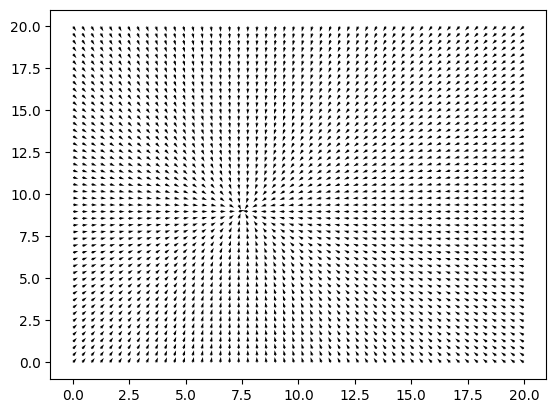

In [8]:
grid_points = create_mesh_grid([[0, 20], [0, 20]])
gradients = gradient(grid_points)
plot_vector_field(grid_points, gradients)

### Train the Model

In [9]:
# Define a very simple model for the score.
score_model = nn.Sequential(
    nn.Linear(input_dim, 128), nn.SiLU(),
    nn.Linear(128, 128), nn.SiLU(),
    nn.Linear(128, input_dim)
)
device = "cuda" # or None
score_model = score_model.to(device)

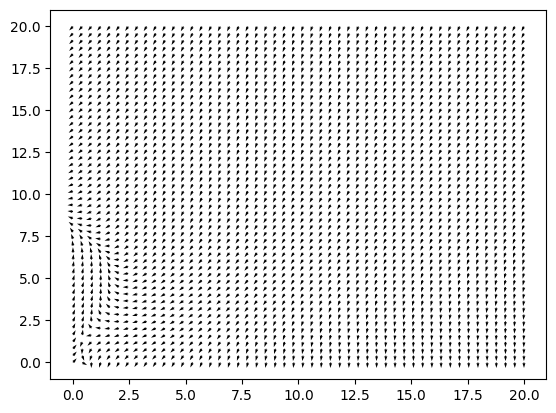

In [10]:
# Plot the gradient of the untrained model.
gradients = score_model(grid_points.to(device)).squeeze(1).cpu().detach().numpy()
plot_vector_field(grid_points, gradients)

In [11]:
# Obtain training data and set up a training data loader.
N_samples = 10000
data = mvn.sample((N_samples, ))
training_data_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

In [12]:
# Train the model.
N_epochs = 10
lr = 0.0001

training_loss = loss_ESM
#training_loss = partial(loss_SSM, M=1)
# DSM requires more epochs to have good quality, it's also sensitive to setting sigma right.
#training_loss = partial(loss_DSM, sigma=0.1)

train(score_model, training_loss, training_data_loader, N_epochs=N_epochs, lr=lr, device=device)

Epoch 1, loss: -0.613893985748291
Epoch 2, loss: -0.5542047619819641
Epoch 3, loss: -0.8969288468360901
Epoch 4, loss: -0.6557509899139404
Epoch 5, loss: -0.7615022659301758
Epoch 6, loss: -0.35833972692489624
Epoch 7, loss: -0.19413581490516663
Epoch 8, loss: -0.5896745920181274
Epoch 9, loss: -0.5161147117614746
Epoch 10, loss: -0.6496680974960327

Best loss: -1.0559557676315308


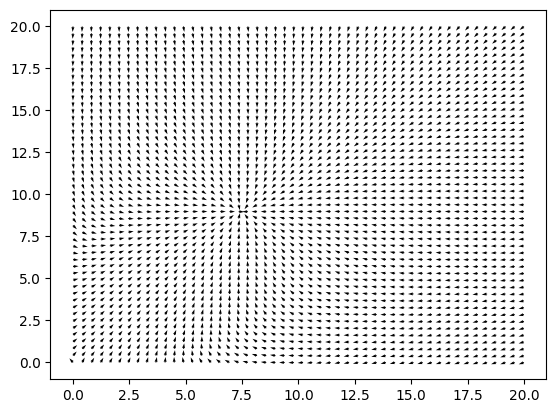

In [13]:
# Plot the gradient of the trained model.
gradients = score_model(grid_points.to(device)).squeeze(1).cpu().detach().numpy()
plot_vector_field(grid_points, gradients)